
[ESN]
Accuracy: 0.6046862518860389
F1-score (DoS): 0.31603194103194104
F1-score (Normal): 0.7220072400449382
Confusion Matrix:
 [[11568  3803]
 [ 5105  2058]]
              precision    recall  f1-score   support

      normal       0.69      0.75      0.72     15371
         dos       0.35      0.29      0.32      7163

    accuracy                           0.60     22534
   macro avg       0.52      0.52      0.52     22534
weighted avg       0.58      0.60      0.59     22534


[RC with Jerk (PCA)]
Accuracy: 0.7889855329723973
F1-score (DoS): 0.6710935878813031
F1-score (Normal): 0.8446636829897749
Confusion Matrix:
 [[12928  2443]
 [ 2312  4851]]
              precision    recall  f1-score   support

      normal       0.85      0.84      0.84     15371
         dos       0.67      0.68      0.67      7163

    accuracy                           0.79     22534
   macro avg       0.76      0.76      0.76     22534
weighted avg       0.79      0.79      0.79     22534



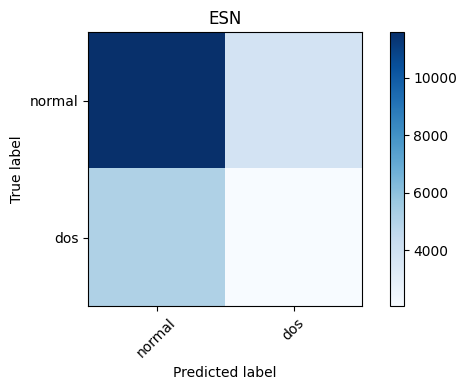

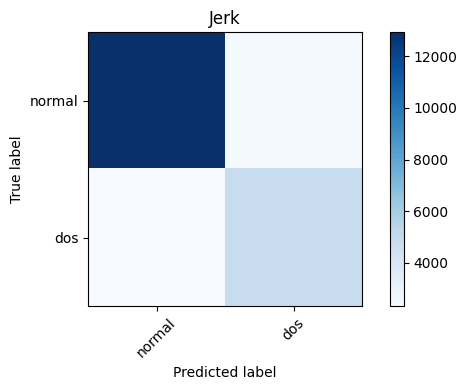

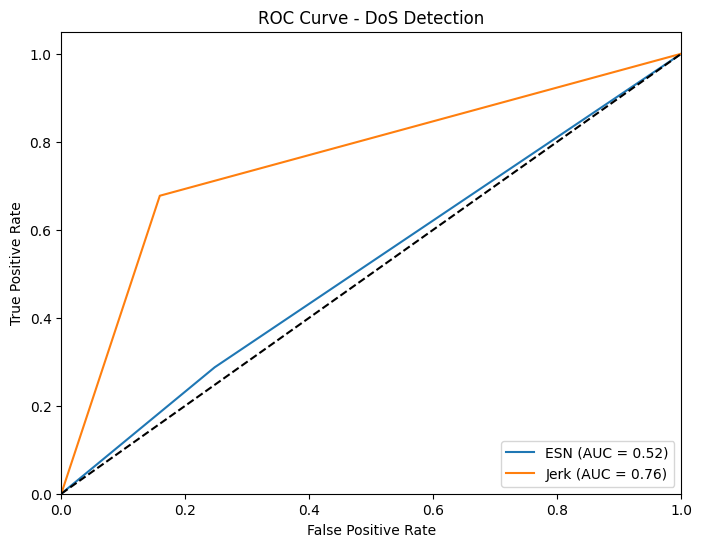

In [1]:
# main5.ipynb - Fair Comparison: DoS vs Normal Detection using Unified Preprocessing

# === 1. Imports and Initial Configurations ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from pyESN import ESN
from scipy.integrate import solve_ivp

# === 2. Data Loading and Unified Preprocessing ===

# Define dataset column names
kdd_columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
    'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
    'label','difficulty'
]

# Load training and testing datasets
train_df = pd.read_csv('KDDTrain+.txt', header=None)
test_df = pd.read_csv('KDDTest+.txt', header=None)
train_df.columns = kdd_columns
test_df.columns = kdd_columns

# Define binary target: 0 for normal, 1 for DoS attacks
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'udpstorm', 'processtable']
train_df['target'] = train_df['label'].apply(lambda x: 1 if x in dos_attacks else 0)
test_df['target'] = test_df['label'].apply(lambda x: 1 if x in dos_attacks else 0)

# Remove label and difficulty columns
X_train_raw = train_df.drop(columns=['label', 'difficulty', 'target'])
y_train = train_df['target']
X_test_raw = test_df.drop(columns=['label', 'difficulty', 'target'])
y_test = test_df['target']

# Apply label encoding to categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    encoder = LabelEncoder()
    X_train_raw[col] = encoder.fit_transform(X_train_raw[col])
    X_test_raw[col] = encoder.transform(X_test_raw[col])

# Normalise features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Apply PCA uniformly to all models
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === 3. Sequence Creation ===
def create_sequences(data, targets, window_size=10):
    # Generate sequences of a fixed window size with corresponding target
    X = np.array([data[i:i+window_size] for i in range(len(data) - window_size)])
    y = np.array([targets.iloc[i+window_size-1] for i in range(len(targets) - window_size)])
    return X, y

X_train_seq, y_train_seq = create_sequences(pd.DataFrame(X_train_pca), y_train)
X_test_seq, y_test_seq = create_sequences(pd.DataFrame(X_test_pca), y_test)

# === 4. Model Evaluation Function ===
def evaluate_model(name, y_true, y_pred):
    # Print standard classification metrics
    print(f"\n[{name}]")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score (DoS):", f1_score(y_true, y_pred, pos_label=1))
    print("F1-score (Normal):", f1_score(y_true, y_pred, pos_label=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=['normal', 'dos']))

# === 6. Echo State Network (ESN) ===
esn = ESN(n_inputs=X_train_seq.shape[2], n_outputs=1, 
          n_reservoir=500, spectral_radius=1.25, sparsity=0.05, random_state=42)

# Use mean of each sequence as input to train the ESN
X_train_avg_seq = np.mean(X_train_seq, axis=1)
esn.fit(X_train_avg_seq, y_train_seq.reshape(-1, 1))

# Extract dynamic statistical features from ESN output
def extract_esn_features(esn, X):
    features = []
    for seq in X:
        out = esn.predict(np.mean(seq, axis=0).reshape(1, -1))
        stats = np.hstack([out.mean(), out.std(), out[-1]])
        features.append(stats)
    return np.array(features)

X_train_esn = extract_esn_features(esn, X_train_seq)
X_test_esn = extract_esn_features(esn, X_test_seq)

clf_esn = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_esn.fit(X_train_esn, y_train_seq)
y_pred_esn = clf_esn.predict(X_test_esn)
evaluate_model("ESN", y_test_seq, y_pred_esn)

# === 7. Jerk System Based Reservoir Computing ===
def jerk_system(t, state, u):
    x, y, z = state
    dx = y
    dy = z
    dz = -z - x - 1e-9 * (np.exp(y / 0.026) - 1) + u
    return [dx, dy, dz]

def simulate_jerk(signal, dt=0.1):
    state = [0.0, 0.0, 0.0]
    states = []
    for u in signal:
        sol = solve_ivp(lambda t, y: jerk_system(t, y, u), [0, dt], state, method='RK45')
        state = sol.y[:, -1]
        states.append(state)
    return np.array(states)

# Use the mean signal across features and flatten jerk response as features
X_train_jerk = np.array([simulate_jerk(np.mean(seq, axis=1)).flatten() for seq in X_train_seq])
X_test_jerk = np.array([simulate_jerk(np.mean(seq, axis=1)).flatten() for seq in X_test_seq])

clf_jerk = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_jerk.fit(X_train_jerk, y_train_seq)
y_pred_jerk = clf_jerk.predict(X_test_jerk)
evaluate_model("RC with Jerk (PCA)", y_test_seq, y_pred_jerk)

# === 8. Visualisation ===
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes = ['normal', 'dos']
plot_confusion_matrix(confusion_matrix(y_test_seq, y_pred_esn), classes, "ESN")
plot_confusion_matrix(confusion_matrix(y_test_seq, y_pred_jerk), classes, "Jerk")
plt.show()

# Plot ROC curves for all models on the same figure
plt.figure(figsize=(8,6))
for name, y_pred in [('ESN', y_pred_esn), ('Jerk', y_pred_jerk)]:
    fpr, tpr, _ = roc_curve(y_test_seq, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DoS Detection')
plt.legend(loc="lower right")
plt.show()


NameError: name 'fontname' is not defined

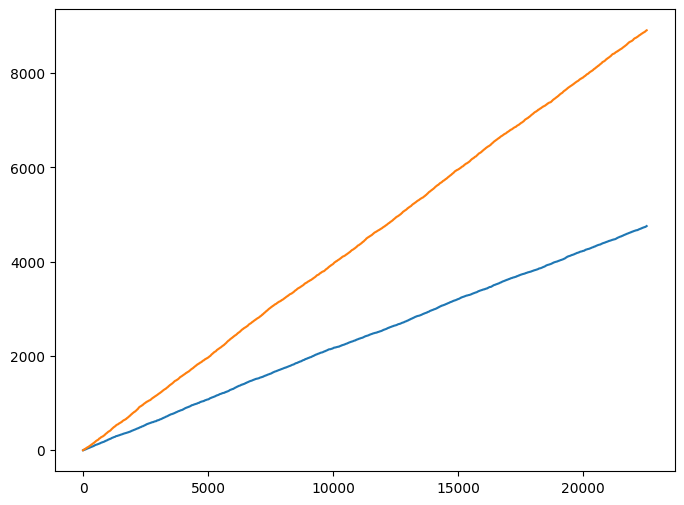

In [2]:
# Figure 5: Cumulative errors over time
fontsize = 16
plt.figure(figsize=(8, 6))
errors = {
    #'Baseline': np.cumsum(y_pred_base[:sample_size] != y_test_seq[:sample_size]),
    'Jerk': np.cumsum(y_pred_jerk != y_test_seq),
    'ESN': np.cumsum(y_pred_esn != y_test_seq)
}
for model, error in errors.items():
    plt.plot(error, '-', label=model)
plt.title('Cumulative Classification Errors Over Time', fontsize=fontsize, fontname=fontname)
plt.xlabel('Sample Index', fontsize=fontsize, fontname=fontname)
plt.ylabel('Cumulative Errors', fontsize=fontsize, fontname=fontname)
plt.legend(fontsize=fontsize -4 )
plt.xticks(fontsize=fontsize, fontname=fontname)
plt.yticks(fontsize=fontsize, fontname=fontname)
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('fig_cumulative_errors.svg', format='svg')
plt.show()